In [45]:
# Import necessary libraries
import boto3
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Specify the AWS CLI profile to use
AWS_PROFILE = "AWS_PROFILE_CLI"

# Initialize a session using the specified profile
# Specify the region explicitly when initializing the session
session = boto3.Session(profile_name=AWS_PROFILE, 
                        region_name="us-east-2")  # Replace with the correct region

# Create the correct Bedrock client and perform an API call
try:
    # Use 'bedrock' for management APIs (e.g., listing models)
    bedrock_agent_runtime = session.client("bedrock-agent-runtime")
    logging.info("AWS bedrock-agent-runtime initialized successfully using profile '%s'.", AWS_PROFILE)
except Exception as e:
    logging.error("Failed to interact with Bedrock client: %s", str(e))

2024-12-26 13:03:43,695 - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2024-12-26 13:03:44,025 - INFO - AWS bedrock-agent-runtime initialized successfully using profile 'AWS_PROFILE_CLI'.


In [ ]:
# !pip install qdrant-client pdfplumber sentence-transformers

In [3]:
from qdrant_client import QdrantClient

# Initialize Qdrant client in-memory
client = QdrantClient(":memory:")

# Logging
import logging
logging.info("Initialized Qdrant in-memory client successfully.")

2024-12-26 11:49:06,722 - INFO - Initialized Qdrant in-memory client successfully.


In [ ]:
import pdfplumber
import logging
import time

# Configure logging to include page numbers and timing
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Function to extract text from a PDF with enhanced logging
def extract_pdf_text_with_logging(pdf_path):
    with pdfplumber.open(pdf_path) as pdf:
        text = ""
        total_pages = len(pdf.pages)
        logging.info("PDF contains %d pages. Starting extraction...", total_pages)
        
        for i, page in enumerate(pdf.pages):
            logging.info("Starting processing for page %d...", i + 1)
            start_time = time.time()  # Track start time
            
            try:
                page_text = page.extract_text()
                if page_text:
                    text += page_text + "\n"
                    end_time = time.time()  # Track end time
                    logging.info(
                        "Successfully processed page %d of %d. Characters extracted: %d. Time taken: %.2f seconds.",
                        i + 1, total_pages, len(page_text), end_time - start_time
                    )
                else:
                    logging.warning("No text found on page %d of %d.", i + 1, total_pages)
            except Exception as e:
                logging.error("Failed to process page %d: %s", i + 1, str(e))
        logging.info("PDF text extraction complete.")
    return text

# Path to your PDF file
pdf_path = "mdx_dashboard_assist/agent-2022-acura-mdx-owner-manual/2022-acura_mdx_manual.pdf"

# Extract text with progress logging
try:
    manual_text = extract_pdf_text_with_logging(pdf_path)
    logging.info("Text extraction finished.")
except Exception as e:
    logging.error("Failed to extract text from PDF: %s", str(e))

In [12]:
# Function to split text into smaller chunks
def chunk_text(text, chunk_size=500):
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size):
        chunks.append(" ".join(words[i:i + chunk_size]))
    return chunks

# Generate chunks from manual_text
try:
    chunks = chunk_text(manual_text)  # Use manual_text instead of manual_data
    logging.info("Text divided into %d chunks.", len(chunks))
except Exception as e:
    logging.error("Failed to chunk the text: %s", str(e))

2024-12-26 12:11:34,523 - INFO - Text divided into 277 chunks.


In [ ]:
from sentence_transformers import SentenceTransformer

# Initialize the embedding model
try:
    model = SentenceTransformer("all-MiniLM-L6-v2")
    logging.info("Embedding model loaded successfully.")
except Exception as e:
    logging.error("Failed to load embedding model: %s", str(e))

# Generate embeddings for all chunks
try:
    embeddings = [model.encode(chunk) for chunk in chunks]
    logging.info("Generated embeddings for all %d chunks.", len(embeddings))
except Exception as e:
    logging.error("Failed to generate embeddings: %s", str(e))

In [16]:
# Check if collection exists and create it if not
from qdrant_client.models import VectorParams

collection_name = "acura_manual"

try:
    if not client.collection_exists(collection_name=collection_name):
        client.create_collection(
            collection_name=collection_name,
            vectors_config=VectorParams(
                size=len(embeddings[0]),  # Embedding dimensionality
                distance="Cosine"  # Similarity metric
            )
        )
        logging.info("Qdrant collection '%s' created successfully.", collection_name)
    else:
        logging.info("Qdrant collection '%s' already exists.", collection_name)
except Exception as e:
    logging.error("Failed to create or verify Qdrant collection: %s", str(e))

2024-12-26 12:15:13,116 - INFO - Qdrant collection 'acura_manual' already exists.


In [19]:
# Upload embeddings and chunks with page numbers to Qdrant
try:
    points = [
        PointStruct(
            id=i,
            vector=embeddings[i],
            payload={
                "text": chunks[i],  # The chunked text
                "page": i + 1       # Dummy page number (update if actual page numbers are available)
            }
        ) for i in range(len(chunks))
    ]
    client.upsert(collection_name=collection_name, points=points)
    logging.info("Successfully stored embeddings and chunks with page numbers in Qdrant.")
except Exception as e:
    logging.error("Failed to upload data to Qdrant: %s", str(e))

2024-12-26 12:18:04,465 - INFO - Successfully stored embeddings and chunks with page numbers in Qdrant.


In [ ]:
# Function to query Qdrant for relevant chunks with page numbers
def query_qdrant_with_pages(query, collection_name, top_k=3):
    try:
        # Generate embedding for the query
        query_embedding = model.encode(query)
        
        # Perform similarity search
        search_results = client.search(
            collection_name=collection_name,
            query_vector=query_embedding,
            limit=top_k  # Number of results to return
        )
        
        # Display the results
        for result in search_results:
            logging.info(
                "Score: %.4f, Page: %d, Text: %s",
                result.score, result.payload.get("page", -1), result.payload["text"]
            )
        return search_results
    except Exception as e:
        logging.error("Failed to query Qdrant: %s", str(e))
        return []

# Example query
user_query = "What to do when the tire pressure is low?"

# Query Qdrant and retrieve results
results = query_qdrant_with_pages(user_query, collection_name="acura_manual")


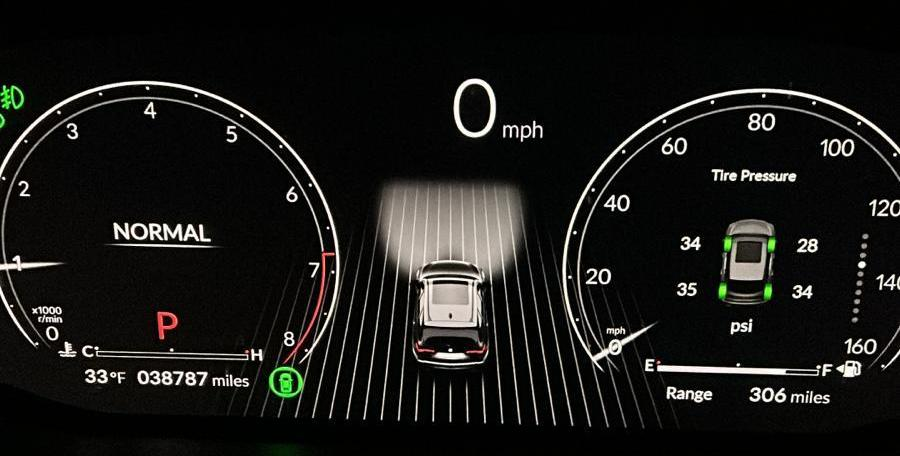

In [57]:
from IPython.display import Image
import base64

# Path to the image file
image_path = "mdx_dashboard_assist/2024-12-12-Dashboard-1.jpeg"

# Encode the image in Base64
with open(image_path, "rb") as image_file:
    image_base64 = base64.b64encode(image_file.read()).decode("utf-8")

# Create a data URI for the image
data_uri = f"data:image/jpeg;base64,{image_base64}"

# Display the image in the notebook
Image(url=data_uri)

In [27]:
import base64
import logging

# # Path to the image file
# image_path = "mdx_dashboard_assist/2024-12-12-Dashboard-1.jpeg"

# Encode the image in Base64
try:
    with open(image_path, "rb") as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode("utf-8")
    logging.info("Image successfully encoded to Base64.")
except Exception as e:
    logging.error("Failed to encode image to Base64: %s", str(e))

# Prepare the payload for the Bedrock agent
payload = {
    "mode": "Initial-Analysis",  # Specify the action mode
    "imageInput": image_base64
}

# Invoke the Bedrock model
try:
    response = bedrock_client.invoke_model(
        modelId="agent-2022-acura-mdx-owner-manual",  # Replace with the correct model ID
        contentType="application/json",
        accept="application/json",
        body=str(payload)  # Convert payload to JSON string
    )
    # Parse and log the response
    response_text = response['body'].read().decode('utf-8')
    logging.info("Initial analysis response from Bedrock: %s", response_text)
except Exception as e:
    logging.error("Failed to invoke Bedrock agent: %s", str(e))

2024-12-26 12:37:18,253 - INFO - Image successfully encoded to Base64.
2024-12-26 12:37:18,254 - ERROR - Failed to invoke Bedrock agent: 'Bedrock' object has no attribute 'invoke_model'


In [70]:
# Prepare the payload for interacting with the Bedrock agent
interaction_payload = {
    "mode": "Initial-Analysis",  # Specify the action mode
    "imageInput": image_base64,  # Base64-encoded image
    "textInput" : " Output should be a JSON response conforming to the OAS with no extra test outside the OAS/JSON structure"
}

In [ ]:
import os
import json
import logging

# Fetch Agent ID and Alias ID from environment variables
agent_id = os.getenv("AWS_BEDROCK_AGENT_ID")
alias_id = os.getenv("AWS_BEDROCK_AGENT_ALIAS_ID")

# Debug: Print environment variables for verification #REMOVE
# print(f"Agent ID: {agent_id}")
# print(f"Alias ID: {alias_id}")

# Check if environment variables are set
if not agent_id or not alias_id:
    raise ValueError("Environment variables AWS_BEDROCK_AGENT_ID and AWS_BEDROCK_AGENT_ALIAS_ID must be set.")

# Prepare the interaction payload
interaction_payload = {
    "mode": "Initial-Analysis",  # Specify the action mode
    "imageInput": image_base64  # Base64-encoded image
}

# # Debug: Print the payload for verification
# print("Payload to be sent to the Bedrock agent:")
# print(json.dumps(interaction_payload, indent=2))

# Interact with the Bedrock agent
try:
    agent_response = bedrock_agent_runtime.invoke_agent(
        agentId=agent_id,
        agentAliasId=alias_id,
        sessionId="test-session",
        inputText=json.dumps(interaction_payload)  # Pass the payload as JSON string
    )

    # Parse and process the EventStream
    completion_stream = agent_response['completion']
    print("Processing EventStream from the agent...")
    print(agent_response)
    for event in completion_stream:
        print(f"Event structure: {event}")


    # Collect raw JSON responses
    raw_json_responses = []

    # Iterate over the streamed response
    for event in completion_stream:
        if 'payload' in event:
            payload = event['payload'].decode('utf-8')
            try:
                json_data = json.loads(payload)
                raw_json_responses.append(json_data)
            except json.JSONDecodeError:
                print(f"Error: Could not parse JSON from payload: {payload}")
        else:
            print("Unexpected event structure:")
            print(event)

    # Print the collected raw JSON responses
    if raw_json_responses:
        print("Full API Response JSON:")
        for response in raw_json_responses:
            print(json.dumps(response, indent=2))
    else:
        print("No JSON responses found in the EventStream.")

except Exception as e:
    logging.error("Failed to interact with Bedrock agent: %s", str(e))
    raise